# Vine Copulas

## General Introduction to Vine Copulas

A vine copula model is a method to construct multivariate copulas with the use of bivariate copulas as building blocks (see [Bivariate Copulas](https://vinecopulas.readthedocs.io/en/latest/bivariatecopulas.html)) (Czado & Nagler, 2021). The basis of a vine copula is conditioning (Aas et al., 2009; Czado & Nagler, 2021). 

A set of linked trees can be used to describe a vine copula. Each tree consists of nodes and edges, where nodes represent variables, and edges represent the dependencies between them, as illustrated in Figure 1.


<figure>
  <img src="vinceopulastructure.png" alt="Vine Copula Structure" >
  <figcaption>Figure 1: Tree structure of a vine copula.</figcaption>
</figure>


For a $d$-dimensional vine distribution, the first tree, $T_1$, identifies $d − 1$ pairs of variables (edges),
whose distribution is modeled directly between the variables. This is showcased in Figure 1, where there are four variables  ($d=4$), and there are three pairs. The second tree,  $T_2$, identifies $d − 2$  pairs of variables, whose distribution, conditional on a single variable, is modeled
by a pair-copula. in $T_2$ the first conditioning variables are determined, which in Figure 1 are variable 4 and 3. The proceeding Trees will have $d - i$ pairs, where $i$ is the tree number, until there is only one pair left. The final conditioning set in $T_{d-1}$ consists of all conditioning variables throughout the preceding trees (Dißmannet al., 2013). In Figure 1 it can also be observed that the edges of one tree become the nodes of the next (Czado & Nagler, 2021). Two nodes in $T_{i+1}$ are only connected by an edge if these nodes share a common node in tree $T_{i}$ (Dißmann et al., 2013).

In this tutorial, vine copulas will further be explained with the use of an example dataset. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from vinecopulas.marginals import *
from vinecopulas.vinecopula import *

The data used as an example is the Abalone dataset from the [UCI database](http://archive.ics.uci.edu/ml/datasets/Abalone) and has also been showcased in a chapter on vine copula-based modeling by Czado and Nagler (2021). The data set contains measurements on diameter, length, and several types of weight (whole, shucked, viscera and shell) of abalones, a type of marine snail. For this example, only data on the female snails are included and are loaded below.

In [2]:
datapath = 'https://raw.githubusercontent.com/VU-IVM/vinecopula/develop/doc/sample_data.csv' #path to data
df = pd.read_csv(datapath) #load data
df.head() #show data columns and first rows 

,whole,shuck,vis,shell,diameter,length,rings
0,0.6770,0.2565,0.1415,0.21,0.420,0.530,9
1,0.7775,0.2370,0.1415,0.33,0.415,0.530,20
2,0.7680,0.2940,0.1495,0.26,0.425,0.545,16
3,0.8945,0.3145,0.1510,0.32,0.440,0.550,19
4,0.6065,0.1940,0.1475,0.21,0.380,0.525,14


As explained in the section on [bivariate copulas](https://vinecopulas.readthedocs.io/en/latest/bivariatecopulas.html), in order to fit copulas to the data it needs to be transformed into uniformly distributed marginals. In this example we will do so by determining the best fit distribution of each variable in the dataset and applying the CDF of that distribution to the variable ([probability integral transform](https://vinecopulas.readthedocs.io/en/latest/bivariatecopulas.html#Probability-Integral-Transform)). The best fit distribution and its parameters can be determined using the `best_fit_distribution` function, and the CDF can be calculated using the statistical function provided in `scipy.stats`, as showcased below.


In [3]:
x = np.array(df)[:,:-1] #turn dataframe into an array
u = x.copy() #make a copy of data which will be transformed 
for i in range(len(df.columns[:-1])):
    namedist =  'dist'+ str(i) #define a name for the distribution of each variable
    locals()[namedist] =  best_fit_distribution(x[:,i]) #fit the best fit distribution to each variable
    u[:,i] = locals()[namedist][0].cdf(u[:,i] , *locals()[namedist][1]) #compute the CDF of the variable using the best fit distribution

After transforming the data we can plot both the original data and the transformed data to compare the scatter plots between all the different variables in the dataset.

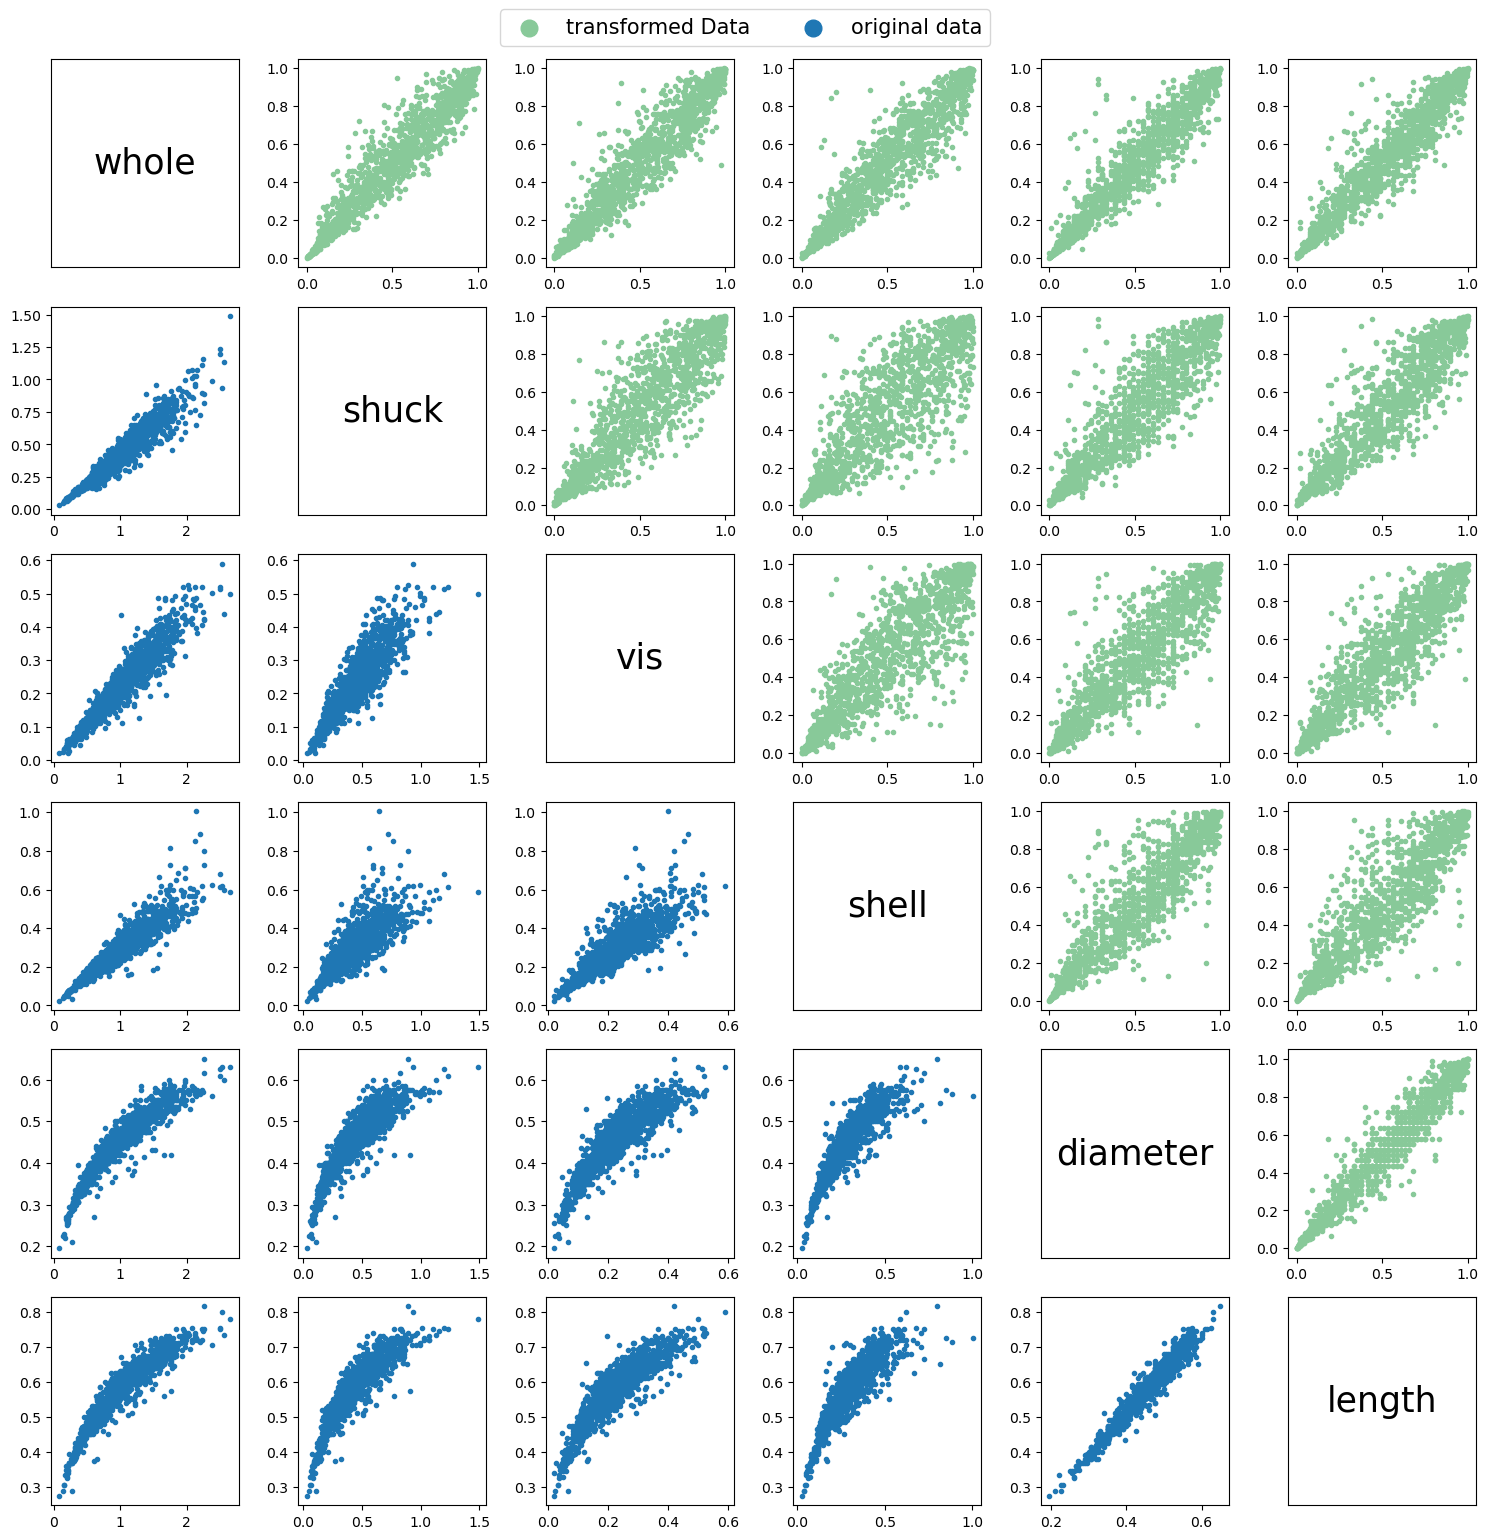

In [4]:
fig, axs = plt.subplots(6, 6, figsize=(15, 15))
ii = 0
jj = 0
for i in range(6):
    for j in range(6):
        ax = axs[i, j]
        if i > j:  # Lower diagonal
            if ii == 0:
                ax.scatter(x[:,j], x[:,i], marker='.', label = "original data", color =  '#1f77b4')
                ii = 1
            else:
                ax.scatter(x[:,j], x[:,i], marker='.',  color =  '#1f77b4')
        elif i < j:  # Upper diagonal
            if jj == 0:
                ax.scatter(u[:,j], u[:,i], marker='.', label  ='transformed Data',color = '#88c999')
                jj = 1
            else: 
                ax.scatter(u[:,j], u[:,i], marker='.',color = '#88c999')
        else:  # Main diagonal
            ax.text(0.5, 0.5, df.columns[i], horizontalalignment='center', verticalalignment='center', fontsize=25, color='black')
            ax.set_xticks([])
            ax.set_yticks([])
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=2,markerscale=4, fontsize=15)
plt.tight_layout()
plt.show()

## Fitting a Vine Copula

Once the data has been transformed, a vine copula can be fit to it. In a vine copula model, each pair of variables is associated with a specific bivariate copula that models the dependence structure between them. These copulae are fitted individually to each pair, capturing the underlying dependency patterns between them. The following table shows the available copula types in this package and their ID. The ID is used as an input parameter in the fitting function to indicate which copula needs to be considered when fitting a vine copula.

**Table 1**


| **ID** | **Copula** | $\mathbf{C(u_1, u_2)}$ | **Parameters** |
|---|---|---|---|
| 1 | Gaussian | $\Phi_{\theta}(\Phi^{-1}(u_1),\Phi^{-1}(u_2))$ | $\theta \in [-1, 1]$ |
| 2 | Gumbel | $\exp \!\left[-\left((-\log(u_1))^{\theta }+(-\log(u_2))^{\theta }\right)^{1/\theta }\right]$ | $\theta \in [1, \infty)$ |
| 3 | Gumbel 90 degrees | $u_2 - \exp \!\left[-\left((-\log(1-u_1))^{\theta }+(-\log(u_2))^{\theta }\right)^{1/\theta }\right]$ | $\theta \in [1, \infty)$ |
| 4 | Gumbel 180 degrees | $u_1 + u_2 - 1 + \exp \!\left[-\left((-\log(1-u_1))^{\theta }+(-\log(1-u_2))^{\theta }\right)^{1/\theta }\right]$ | $\theta \in [1, \infty)$ |
| 5 | Gumbel 270 degrees | $u_1 - \exp \!\left[-\left((-\log(u_1))^{\theta }+(-\log(1- u_2))^{\theta }\right)^{1/\theta }\right]$ | $\theta \in [1, \infty)$ |
| 6 | Clayton | $\left[\max \left\{u_1^{-\theta }+u_2^{-\theta }-1;0\right\}\right]^{-1/\theta}$ | $\theta \in [-1,\infty) \setminus \{0\}$ |
| 7 | Clayton 90 degrees | $u_2 - \left[\max \left\{(1-u_1)^{-\theta }+u_2^{-\theta }-1;0\right\}\right]^{-1/\theta}$ | $\theta \in [-1,\infty) \setminus \{0\}$ |
| 8 | Clayton 180 degrees | $u_1 + u_2 - 1 + \left[\max \left\{(1-u_1)^{-\theta }+(1-u_2)^{-\theta }-1;0\right\}\right]^{-1/\theta}$ | $\theta \in [-1,\infty) \setminus \{0\}$ |
| 9 | Clayton 270 degrees | $u_1 - \left[\max \left\{u_1^{-\theta }+(1-u_2)^{-\theta }-1;0\right\}\right]^{-1/\theta}$ | $\theta \in [-1,\infty) \setminus \{0\}$ |
| 10 | Frank | $-{\frac {1}{\theta }}\log \!\left[1+{\frac {(\exp(-\theta u)-1)(\exp(-\theta v)-1)}{\exp(-\theta )-1}}\right]$ | $\theta \in \mathbb{R} \setminus \{0\}$ |
| 11 | Joe | ${1-\left[(1-u_1)^{\theta }+(1-u_2)^{\theta }-(1-u_1)^{\theta }(1-u_2)^{\theta }\right]^{1/\theta }}$ | $\theta \in [1, \infty)$ |
| 12 | Joe 90 degrees | ${u_2 - (1-\left[(u_1)^{\theta }+(1-u_2)^{\theta }-(u_1)^{\theta }(1-u_2)^{\theta }\right]^{1/\theta }})$ | $\theta \in [1, \infty)$ |
| 13 | Joe 180 degrees | ${u_1 + u_2 -\left[(u_1)^{\theta }+(u_2)^{\theta }-(u_1)^{\theta }(u_2)^{\theta }\right]^{1/\theta }})$ | $\theta \in [1, \infty)$ |
| 14 | Joe 270 degrees | ${u_1 - (1-\left[(1-u_1)^{\theta }+(u_2)^{\theta }-(1-u_1)^{\theta }(u_2)^{\theta }\right]^{1/\theta }})$ | $\theta \in [1, \infty)$ |
| 15 | Student | $T_{\theta_2} \left( T_{\theta_2}^{-1}(u_1), T_{\theta_2}^{-1}(u_2); \theta_1 \right)$ | $\theta_1 \in [-1, 1] \text{ and } \theta_2 \in [0, \infty)$ |

Where:

- $\Phi_{\theta}$ is the bivariate standard normal cumulative distribution function with correlation parameter $\theta$.
- $\Phi^{-1}$ is the inverse of the standard normal cumulative distribution function.
- $T_{\theta_2}$ is the cumulative distribution function (CDF) of the Student's t distribution with $\theta_2$ degrees of freedom.
- $T_{\theta_2}^{-1}$ is the inverse CDF of the Student's t distribution with $\theta_2$ degrees of freedom.


### The Dißmann Algorithm

There are different types of regular vine structures, of which the general R-vin is the most flexible. The specific vine copula types will be showcased in a later subsection. Here, we will focus on a general algorithm to fit an R-vine. A vine copula can be fitted by testing all the different possible vine structures and minimizing the model selection criteria, such as BIC and AIC. This method is feasible when there are only a small amount of variables, for example, there are only 3 possible vine structures for a vine copula of three variables. However, as the number of variables increases, the number of possible vine structures increases exponentially as $d! \times 2^{\frac{{(d-2)(d-3)}}{{2}}-1}$ (Morales Napoles, 2011). This means that with the six variables we are using in this example, there are already over 20,000 possible vine structures. Therefore, the Dißmann algorithm (Dißmann et al., 2013) has been developed, which fits a vine copula by fitting the strongest dependencies first.

***

**Algorithm 1**: The Dißmann Algorithm, a sequential method to select an R-vine model based on Kendall’s
tau.

***

**Input:** Data $U = [\mathbf{u}_{1}, \ldots, \mathbf{u}_{d}]$, of length 𝑛
, i.e., $\mathbf{u}=[𝑢_{11},...,𝑢_{𝑛1}]$

**Output:** R-vine copula specification in the form of triangular matrices, $M$, $P$ and $C$.

1. Calculate the empirical Kendall’s tau $\hat{\tau}_{j,k}$ for all possible variable pairs ${j, k}$, $1 \leq j < k \leq d$.
2. Select the spanning tree that maximizes the sum of absolute empirical Kendall’s taus, i.e.,

   $$
   \max \sum_{e=\{j,k\} \text{ in spanning tree}} |\hat{\tau}_{j,k}|.
   $$
   
3. For each edge $\{j, k\}$ in the selected spanning tree, select a copula and estimate the corresponding parameter(s). Then transform $C_{j|k}( \mathbf{u}_{j}|\mathbf{u}_{k})$ and $C_{k|j}( \mathbf{u}_{k}|\mathbf{u}_{j})$ using the fitted copula  ${C}_{jk}$.
4. **for** $i = 2, \ldots, d - 1$ **do** {Iteration over the trees}
      
   1. Calculate the empirical Kendall’s tau $\hat{\tau}_{j,k|D}$ for all conditional variable pairs $\{j, k|D\}$ that can be part of tree $T_i$, i.e., two nodes that share a node in $T_{i-1}$.
    2. Among these edges, select the spanning tree that maximizes the sum of absolute empirical Kendall’s taus, i.e.,

   $$
   \max \sum_{e=\{j,k|D\} \text{ in spanning tree}} |\hat{\tau}_{j,k|D}|.
   $$
   
    3. For each edge $\{j, k|D\}$ in the selected spanning tree, select a conditional copula and estimate the corresponding parameter(s). Then transform
   $C_{j|k \cup D}(\mathbf{u}_{j}|\mathbf{u}_{k}, \mathbf{u}_{D})$ and  $C_{k|j \cup D}(\mathbf{u}_{k}|\mathbf{u}_{j}, \mathbf{u}_{D})$, using the fitted copula $C_{j,k|D}$.
8. **end for**

***

While in $T_1$ the pseudo data to which the copulae will be fit are just the transformed variables in $U$,  in subsequent trees,  $(T_{2}, \ldots, T_{d-1})$, the pseudo data are the conditional CDF's of the edges in the previous tree (see conditional CDF bivariate copula). For example, in Fig.1, $T_1$, Node $1$ and $3$ are connected by edge $\{1,3\}$, and node $3$ and $4$ are connected by edge $\{3,4\}$. The edges $\{1,3\}$ and  $\{3,4\}$ become nodes in $T_2$, and can be connected by an edge because they share a common node in the previous tree, node $3$. As node $3$ is their common node, this becomes the conditioning variable. Therefore, to fit  $C_{1,4|3}$, the pseudo data is as follows:

$$
\mathbf{u}_{1|3} = {C_{1|3}(\mathbf{u}_{1}|\mathbf{u}_{3})} 
\quad \textrm{and} \quad
\mathbf{u}_{4|3} = {C_{4|3}(\mathbf{u}_{4}|\mathbf{u}_{3})} 
\tag{1}
$$

Such that the copula for edge $\{1,4|3\}$ can be fitted as ${C_{1,4|3}(\mathbf{u}_{1|3},\mathbf{u}_{4|3})}$ (Czado and Nagler, 2021).

To fit a vine copula based on Algorithm 1, the `vinecop` function can be used, and plotted using the `plotvine`, as showcased below.

** Tree:  1
1,0  --->  Gumbel180 : parameters =  5.646871761976745
3,0  --->  Gumbel180 : parameters =  4.891363224790164
2,0  --->  Gumbel180 : parameters =  4.948878429854219
0,5  --->  Gumbel180 : parameters =  5.3262714582891615
4,5  --->  Gumbel180 : parameters =  6.401980791083808
** Tree:  2
1,3|0  --->  Student : parameters =  [-0.6498728754754225, 5.696870994081602]
3,2|0  --->  Gumbel90 : parameters =  1.1535165229702633
2,5|0  --->  Gumbel0 : parameters =  1.0604224244297584
0,4|5  --->  Student : parameters =  [0.4024356978634496, 6.066474582174772]
** Tree:  3
1,2|3,0  --->  Student : parameters =  [-0.42128958408740463, 5.716884429181609]
3,5|2,0  --->  Gumbel180 : parameters =  1.038433644248748
2,4|5,0  --->  Frank : parameters =  -0.47973267878183024
** Tree:  4
1,5|2,3,0  --->  Student : parameters =  [0.20298151877339482, 16.05712143922197]
3,4|5,2,0  --->  Frank : parameters =  1.491282667777451
** Tree:  5
1,4|5,2,3,0  --->  Gaussian : parameters =  0.0505800698616

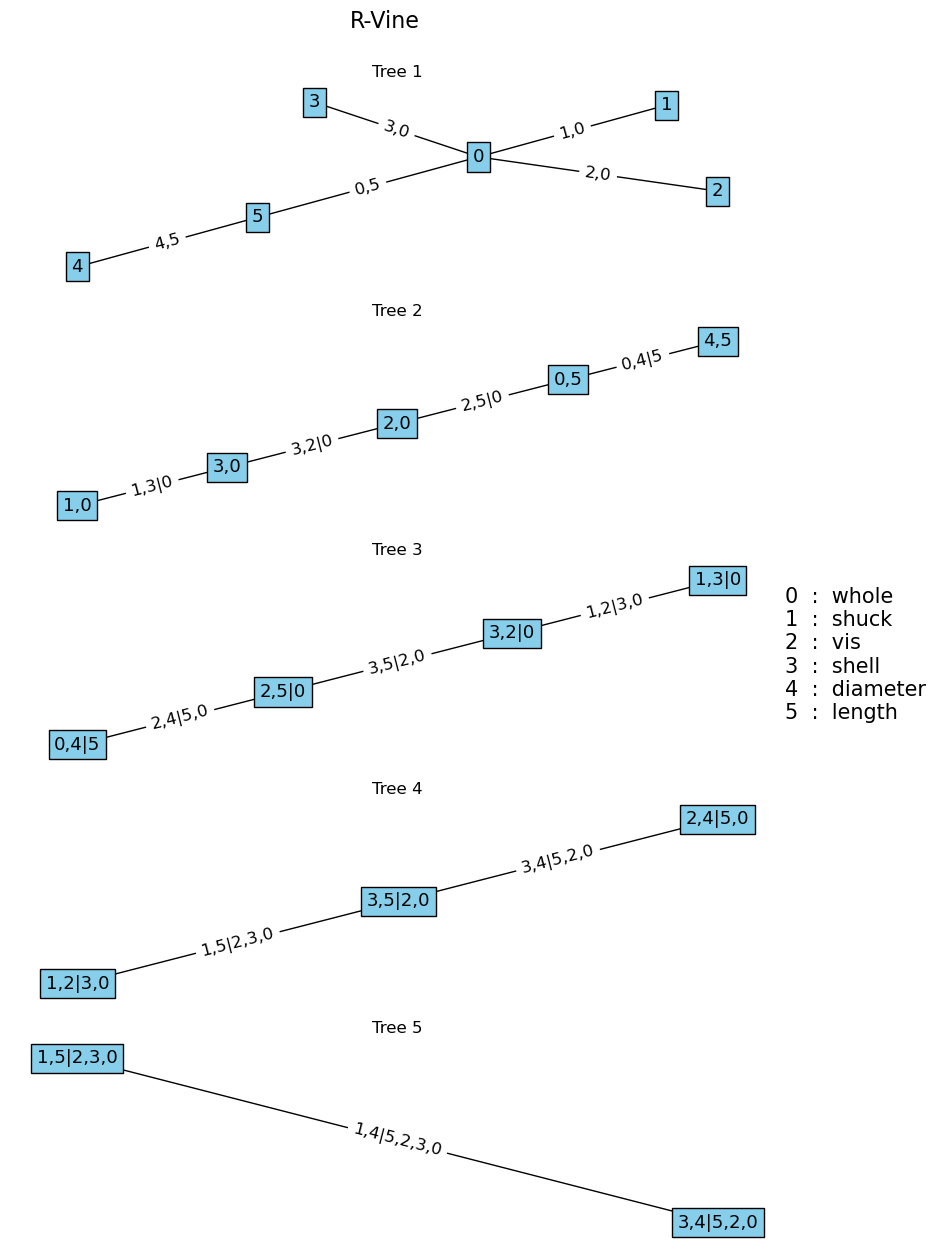

In [5]:
cops = list(range(1,16)) # fit vine copula according to these copulas
M, P, C = vinecop(u, cops, vine = 'R') #fit R-vine 
plotvine(M,variables = list(df.columns[:-1]), plottitle = 'R-Vine') #plot structure

### Vine Copula Types
<figure>
  <img src="vinecopulatypes.png" alt="Vine Copula Structure" >
  <figcaption>Figure 2: Different vine copula types.</figcaption>
</figure>

As indicated previously, there are different types of regular vines, known as, Drawable Vine (D-vine) and  Canonical Vine (C-Vine) (see Figure 2). 

#### D-vine

A D-vine structure consists of only trees that are paths. This means that all nodes, with the exception of two, have a neighbor on each side of it. In a D-vine sequence, $T_1$ already determines all pairs in the subsequent trees. Therefore, to define a D-vine structure, only the path in $T_1$ needs to be specified, also referred to as the order of a
D-vine (Czado & Nagler, 2021).

#### C-vine
in a C-vine, every tree contains a single node, called the root, that is connected to all the other nodes. Therefore, the trees in a C-vine look like stars, until there are only 3 nodes left, in which case the remaining trees take the same structure as a D-vine (Czado & Nagler, 2021).

Both C- and D-vines can be fitted using a slightly adapted Dißmann algorithm. For D-vines, the path is chosen that maximizes the sum of absolute empirical Kendall's $\tau$, and for C-vines, the root node is identified that maximizes the sum
of absolute empirical Kendall's $\tau$ (Czado & Nagler, 2021).

both a C-vine and a D-vine can also be fitted using the `vinecop` function, by specifying the argument _vine_ as either _'D'_ or _'C'_.  


## Matrix Representation of a Vine Copula

Morales Napoles (2011) developed a method to encode complex vine copula models into a triangular matrix representation. For example, the R-vine copula structure, that has just been fitted using the _vinecop_ function, can be represented as:

$$
M = 
\left( \begin{array}{cccccc}
0 & 0 & 0 & 5 & 5 & 5 \\
3 & 2 & 5 & 4 & 4 &  \\
2 & 5 & 4 & 0 &  &  \\
5 & 4 & 2 &  &  &  \\
4 & 3 &  &  &  &  \\
1 &  &  &  &  &  \\
\end{array} \right)
$$

where $M$ is a $d\times d$ sized matrix that can be read as follows:

- if $i = 1$, the label of the $j$-th edge in $T_i$ is given by  $\{m_{d-j+1, j}, m_{i,j}\}$. for example, as dimension $d=6$, the first edge ($j = 1$) of the first tree ($i=1$) is $\{m_{6-1+1, 1}, m_{1,1}\} = \{m_{6,1}, m_{1,1}\}  = \{1, 0\}$
- if $i > 1$, the label of the $j$-th edge  in $T_i$ is given by $\{m_{d-j+1,j}, m_{i,j}; m_{i-1,j}, ..., m_{1,j})$. for example,the first edge ($j = 1$) of the second tree ($i=2$) is $\{m_{6-1+1, 1}, m_{2,1}; m_{2-1,1}\} =\{ m_{6,1}, m_{2,1}; m_{1,1}\} = \{1,3;0\}$


Dißmann et al. (2013) have further employed the matrix structure to also represent the types and parameters of the corresponding bivariate copulas, such that:

\begin{equation*}
M = 
\left( \begin{array}{cccccc}
\bf{\color{fuchsia}{m_{1,1}}} & \color{blueviolet}{m_{1,2}}& m_{1,3} & m_{1,4} & m_{1,5} & m_{1,6} \\
m_{2,1} & \color{blueviolet}{m_{2,2}} & m_{2,3} & m_{2,4} & m_{2,5} &  \\
m_{3,1} &  \bf{\color{blueviolet}{m_{3,2}}} & m_{3,3} & m_{3,4} &  &  \\
m_{4,1} & {m_{4,2}} & m_{4,3} &  &  &  \\
m_{5,1} & \color{blueviolet}{m_{5,2}} &  &  &  &  \\
\color{fuchsia}{m_{6,1}} &  &  &  &  &  \\
\end{array} \right)
P =
\left( \begin{array}{cccccc}
\bf{\color{fuchsia}{p_{1,1}}}& p_{1,2} & p_{1,3} & p_{1,4} & p_{1,5} & p_{1,6} \\
p_{2,1} & p_{2,2} & p_{2,3} & p_{2,4} & p_{2,5} &  \\
p_{3,1} & \bf{\color{blueviolet}{p_{3,2}}} & p_{3,3} & p_{3,4} &  &  \\
p_{4,1} & p_{4,2} & p_{4,3} &  &  &  \\
p_{5,1} & p_{5,2} &  &  &  &  \\
p_{6,1} &  &  &  &  &  \\
\end{array} \right)
\end{equation*}

\begin{equation*}
C =
\left( \begin{array}{cccccc}
\bf{\color{fuchsia}{c_{1,1}}}& c_{1,2} & c_{1,3} & c_{1,4} & c_{1,5} & c_{1,6} \\
c_{2,1} & c_{2,2} & c_{2,3} & c_{2,4} & c_{2,5} &  \\
c_{3,1} & \bf{\color{blueviolet}{c_{3,2}}} & c_{3,3} & c_{3,4} &  &  \\
c_{4,1} & c_{4,2} & c_{4,3} &  &  &  \\
c_{5,1} & c_{5,2} &  &  &  &  \\
c_{6,1} &  &  &  &  &  \\
\end{array} \right)
\end{equation*}

The `vinecop` function returns matrices $M$, $P$, and $C$. Where $C$ includes the copula type with the ID number indicated in Table 1. Hence, the R-vine structure fitted above has the following $C$ matrix:

$$
C = 
\left( \begin{array}{cccccc}
4 & 4 & 4 & 4 & 4 &  \\
15 & 3 & 2 & 15 &  &  \\
15 & 4 & 10 &  &  &  \\
15 & 10 &  &  &  &  \\
1 &  &  &  &  &  \\
 &  &  &  &  &  \\
\end{array} \right)
$$





## Generating Random Samples from a Vine Copula

Given the information provided in $M$,$P$ and $C$, random samples can be generated using Algorithm 2 below (Dißmann, 2013).

***

**Algorithm 2**: Generating random samples from a vine copula

***

**Input** R-vine specification in matrix form: $M, T, P$ and the number of desired samples $n$.

**Output** Random observations $X = [\mathbf{x}_1, ..., \mathbf{x}_d]$ from the R-vine specification. 

1. Flip the columns in the  matrices vertically, such that the matrix becomes a lower triangular matrix.
2. Relabel the variables in $M$, such that the variables on the diagonal are ordered from $d$ to $1$, i.e., $m_{k,k} = d - k + 1, k = 1, ..., d$.
3. Generate independent uniform samples $U = [ \mathbf{u}_1, ..., \mathbf{u}_d]$ of length $n$, i.e., $\mathbf{u}_1 = [u_{11}, ..., u_{n1}]$.
4. Define $V^{\text{direct}} = (v^{\text{direct}}_{i,k} | i, k = 1, ..., d)$.
5. Define $V^{\text{indirect}} = (v^{\text{indirect}}_{i,k} | i, k = 1, ..., d)$. 
6. Set $[v^{\text{direct}}_{d,1}, v^{\text{direct}}_{d,2}, ..., v^{\text{direct}}_{d,d}] =[ \mathbf{u}_1, \mathbf{u}_2, ..., \mathbf{u}_d]$.
7. Let $\mathbb{M} = (\mathbf{m}{_{i,k}} | i, k = 1, ..., d)$ with $\mathbf{m}_{i,k} = \max\{{m}_{i,k}, ..., m_{d,k}\}$ for all $k = 1, ..., d - 1$ and $i = k, ..., d$.
8. $\mathbf{x}_1 = v_{\text{direct}_{d,d}}$.
9. **for**   $k = d-1, ....,1$ **do** {Iterate over the columns of $M$}:
    1. **for** $i = k + 1, ....,d$ **do** {Iterate over the rows of $M$}:
        1. **if** $\mathbf{m}_{i,k} = m_{i,k}$, **then**:
           1. Set $z^{(2)}_{i,k} = v^{\text{direct}}_{i,(d - \mathbf{m}_{i,k} + 1)}$.
        2. **else**:
            2. Set $z^{(2)}_{i,k} = v^{\text{indirect}}_{i,(d - \mathbf{m}_{i,k} + 1)}$.
        3. Set $v^{\text{direct}}_{d,k} = h^{-1}(v^{\text{direct}}_{d,k}, z^{(2)}_{i,k} | t_{i,k}, p_{i,k})$.
    2. **end for**

    3. $\mathbf{x}_{d-k+1} = v^{\text{direct}}_{d,k}$.
    4. **for** $i = d, ....,k+1$ **do** {Iterate over the rows of $M$}:
        1. Set $z^{(1)}_{i,k} = v^{\text{direct}}_{i,k}$.
    	2. Set $v^{\text{direct}}_{i-1,k} = h(z^{(1)}_{i,k}, z^{(2)}_{i,k} | t_{i,k}, p_{i,k})$ and $v^{\text{indirect}}_{i-1,k} = h(z^{(2)}_{i,k}, z^{(1)}_{i,k} | t_{i,k}, p_{i,k})$.
    5. **end for**
10. **end for**
11. Sort the columns in $X$ according to the sampling order, such that $X$ is provided in the same order as the original data.

***
Where $h()$ is the [conditional CDF](https://vinecopulas.readthedocs.io/en/latest/bivariatecopulas.html#Conditional-Cumulative-Distribution-Function-(h-function)) and $h^{-1}()$ is the [inverse conditional CDF](https://vinecopulas.readthedocs.io/en/latest/bivariatecopulas.html#Inverse-Conditional-Cumulative-Distribution-Function-(inverse-h-function)).

This Algorithm was designed based on a lower triangular matrix instead, therefore, $M$ is flipped vertically in step 1. For example, with the fitted R-vine above, converting to a lower triangular matrix is as follows:
\begin{equation*}
M = 
\left( \begin{array}{cccccc}
0 & 0 & 0 & 5 & 5 & 5 \\
3 & 2 & 5 & 4 & 4 &  \\
2 & 5 & 4 & 0 &  &  \\
5 & 4 & 2 &  &  &  \\
4 & 3 &  &  &  &  \\
1 &  &  &  &  &  \\
\end{array} \right) 
\longrightarrow
\left( \begin{array}{cccccc}
1 &  &  &  &  &  \\
4 & 3 &  &  &  &  \\
5 & 4 & 2 &  &  &  \\
2 & 5 & 4 & 0 &  &  \\
3 & 2 & 5 & 4 & 4 &  \\
0 & 0 & 0 & 5 & 5 & 5 \\
\end{array} \right)
\end{equation*}


Additionally, for convenience, the Algorithm works well when the sampling order, the diagonal values in the matrix, are ordered from $n$ to $1$. Therefore, in step 2, all the variables are relabeled such that $m_{k,k} = d - k + 1, k = 1, ..., d$. This relabeled matrix is the equivalent of the original matrix, which means it induces the same R-vine. Here is an example, of how matrix $M$ above, is relabeled:


\begin{equation*}
M =
\left( \begin{array}{cccccc}
1 &  &  &  &  &  \\
4 & 3 &  &  &  &  \\
5 & 4 & 2 &  &  &  \\
2 & 5 & 4 & 0 &  &  \\
3 & 2 & 5 & 4 & 4 &  \\
0 & 0 & 0 & 5 & 5 & 5 \\
\end{array} \right)
\longrightarrow
\left( \begin{array}{cccccc}
6 &  &  &  &  &  \\
2 & 5 &  &  &  &  \\
1 & 2 & 4 &  &  &  \\
4 & 1 & 2 & 3 &  &  \\
5 & 4 & 1 & 2 & 2 &  \\
3 & 3 & 3 & 1 & 1 & 1 \\
\end{array} \right)
\end{equation*}

Another critical step, step.5, is defining the maximum matrix, $\mathbb{M}$, where $\mathbb{M} = (\mathbf{m}{_{i,k}} | i, k = 1, ..., d)$ with $\mathbf{m}_{i,k} = \max\{{m}_{i,k}, ..., m_{d,k}\}$, based on the reordered matrix. Meaning that $\mathbf{m}_{i,k}$ is the maximum of all entries in the $k^{th}$ column of $M$ from the bottom up to the $i^{th}$ variable, such that $\mathbb{M}$, for sorted matrix $M$ above, is as follows :



\begin{equation*}
\mathbb{M} =
\left( \begin{array}{cccccc}
6 &  &  &  &  &  \\
5 & 5 &  &  &  &  \\
5 & 4 & 4 &  &  &  \\
5 & 4 & 3 & 3 &  &  \\
5 & 4 & 3 & 2 & 2 &  \\
3 & 3 & 3 & 1 & 1 & 1 \\
\end{array} \right)
\end{equation*}



Based on Algorithm 2, random samples can be generated using the `samplecop` function, as showcased below.


In [6]:
n = len(u)
ui = samplecop(M, P, C, n) #sample vine copula

### Inverse Probability Integral Transform of Random Samples
As described in Bivariate copualas (link), in order to transform the simulated uniform data points to resemble the original data we can use the Inverse Probability Integral Transform, $F_{X}^{-1}(U)$, also known and the inverse cumulative distribution function (CDF). This can be achieved by using the previously fitted distribution and the `pff` function (Percent point function) of `scipy.stats`

In [7]:
xi = ui.copy()
for i in range(len(df.columns[:-1])):
    namedist =  'dist'+ str(i)
    xi[:,i] = locals()[namedist][0].ppf(ui[:,i] , *locals()[namedist][1])


Now both the original data and the random samples can be plotted.

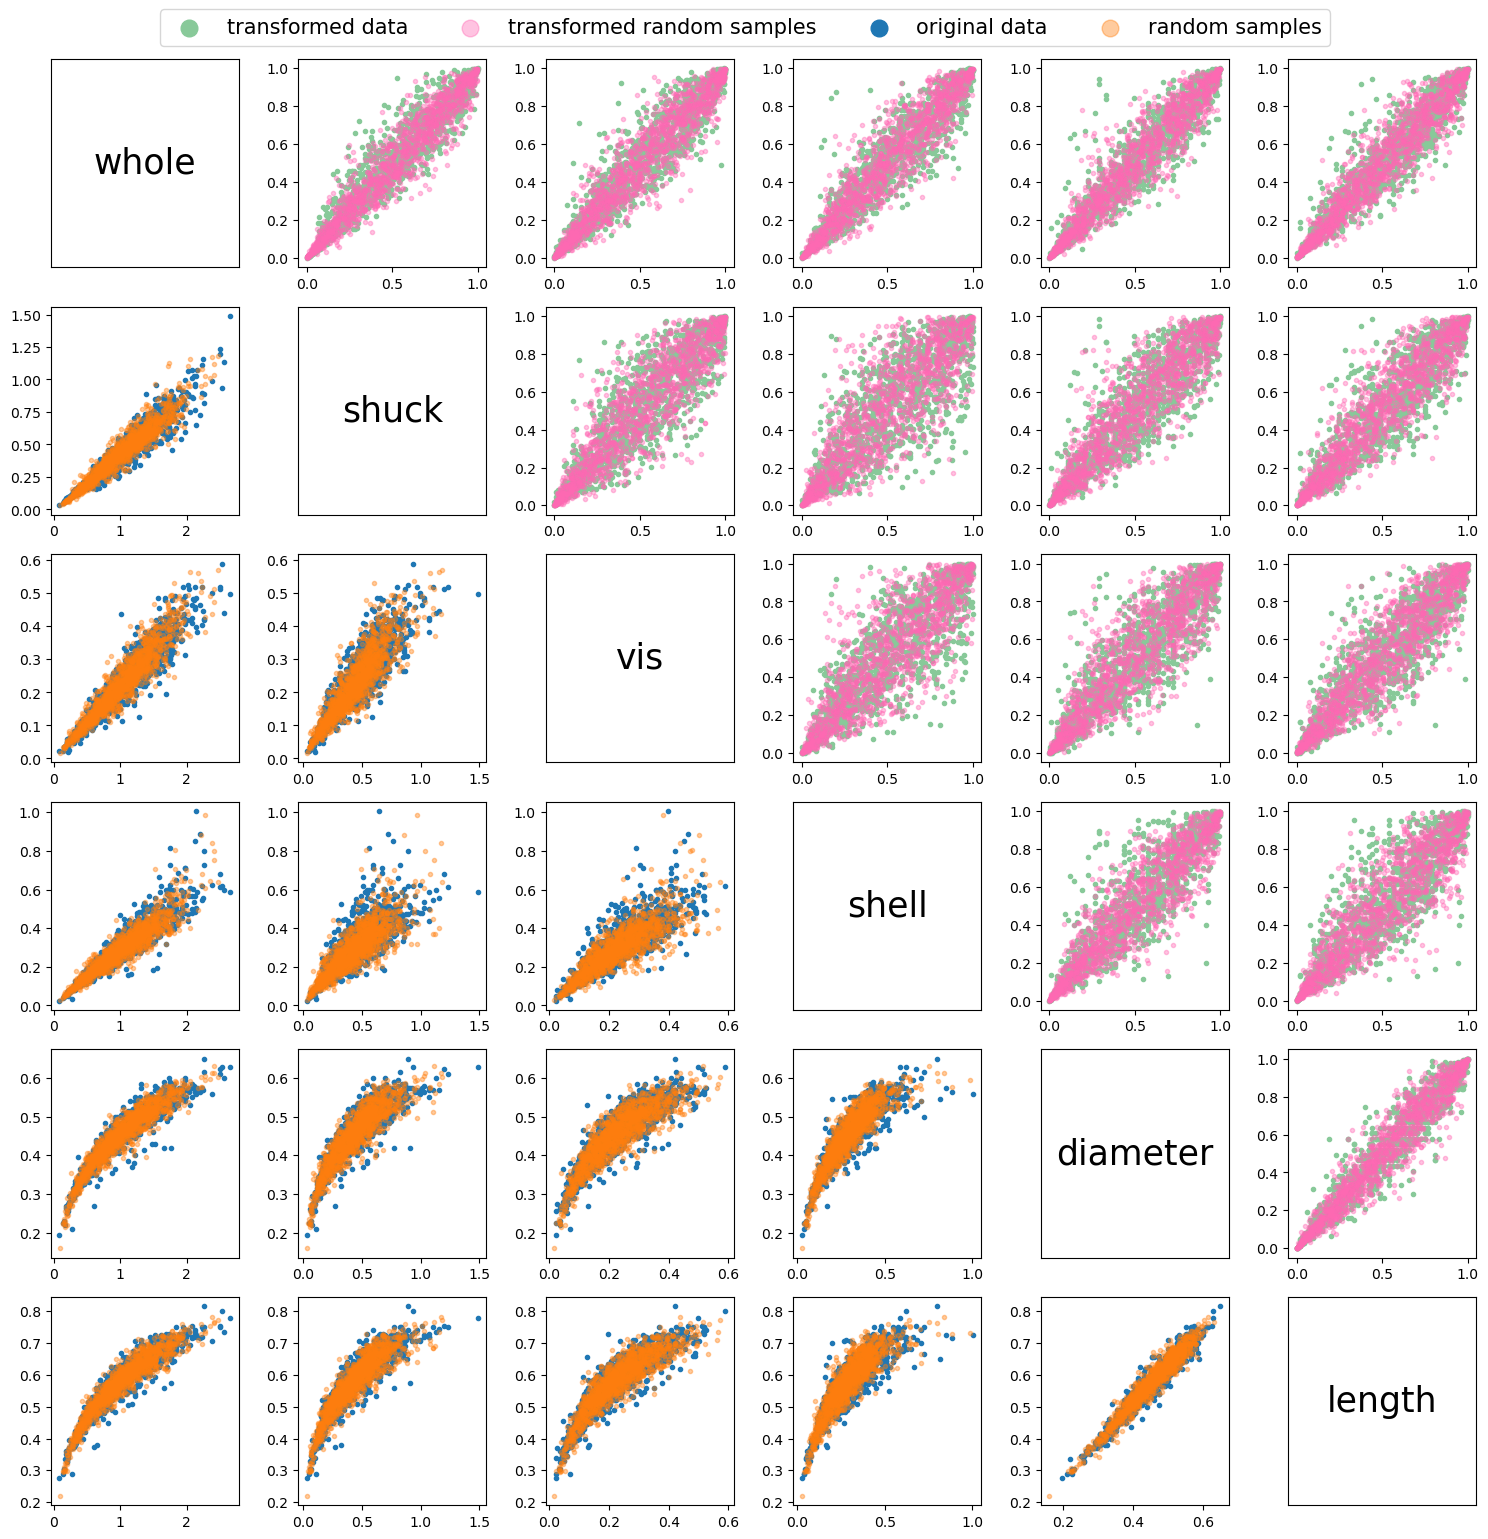

In [8]:
fig, axs = plt.subplots(6, 6, figsize=(15, 15)) # plot random data
ii = 0
jj = 0
for i in range(6):
    for j in range(6):
        ax = axs[i, j]
        if i > j:  # Lower diagonal
            if ii == 0:
        
                ax.scatter(x[:,j], x[:,i], marker='.',label = "original data")
                ax.scatter(xi[:,j], xi[:,i], marker='.', alpha = 0.4, label = "random samples")
                ii = 1
            else:
                ax.scatter(x[:,j], x[:,i], marker='.')
                ax.scatter(xi[:,j], xi[:,i], marker='.', alpha = 0.4)
        elif i < j:  # Upper diagonal
            if jj == 0:
                ax.scatter(u[:,j], u[:,i], marker='.', color = '#88c999',  label  ='transformed data')
                ax.scatter(ui[:,j], ui[:,i], marker='.', alpha = 0.4, color = 'hotpink', label  ='transformed random samples')
                jj = 1
            else:   
                ax.scatter(u[:,j], u[:,i], marker='.', color = '#88c999')
                ax.scatter(ui[:,j], ui[:,i], marker='.', alpha = 0.4, color = 'hotpink')
        else:  # Main diagonal
            ax.text(0.5, 0.5, df.columns[i], horizontalalignment='center', verticalalignment='center', fontsize=25, color='black')
            ax.set_xticks([])
            ax.set_yticks([])
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4,markerscale=4, fontsize=15)
plt.tight_layout()
plt.show()



## Conditional Sampling

### Sampling Orders

As seen in Algorithm 2, the random samples are generated in order of the variables on the diagonal of matrix $M$. For the matrix which has been fitted in this example, the sampling order, $\mathbf{s}$, is showcased in <span style="color:blue"> blue </span> as follows:

\begin{equation*}
S = 
\left( \begin{array}{cccccc}
0 & 0 & 0 & 5 & 5 & \color{blue}{5} \\
3 & 2 & 5 & 4 & \color{blue}{4} &  \\
2 & 5 & 4 & \color{blue}{0} &  &  \\
5 & 4 & \color{blue}{2} &  &  &  \\
4 & \color{blue}{3} &  &  &  &  \\
\color{blue}{1} &  &  &  &  &  \\
\end{array} \right) 
\mathbf{s} = [ \color{blue}{5}, \color{blue}{4}, \color{blue}{0}, \color{blue}{2}, \color{blue}{3}, \color{blue}{1} ]
\end{equation*}

A sampling order can be determined by choosing any of the variables as the first variable, $s_1$, in the sampling order and picking an edge in $T_1$ that includes $s_1$, the second variable in the sampling order, $s_2$, is the other variable in the selected edge. Next, an edge is chosen in $T_2$, which includes both $s_1$ and $s_2$, where $s_3$ is the remaining variable in this chosen edge. This process can be continued until $T_{d-1}$ is reached and all variables have been included in $\mathbf{s}$. For each vine copula with $d$ variables, there are $2^{d-1}$ implied sampling orders (Cooke et al., 2015).

All unique sampling orders, $S$ that a vine copula structure has can be identified with the use of the `samplingorder` function as follows.


In [9]:
Sor = samplingorder(M) #provide all the different sampling orders that are possible
#%% print all samping orders
for i in Sor:
    print(i)
    

[5.0, 4.0, 0.0, 2.0, 3.0, 1.0]
[5.0, 0.0, 2.0, 3.0, 1.0, 4.0]
[5.0, 0.0, 2.0, 3.0, 4.0, 1.0]
[3.0, 0.0, 2.0, 1.0, 5.0, 4.0]
[5.0, 0.0, 2.0, 4.0, 3.0, 1.0]
[3.0, 0.0, 2.0, 5.0, 1.0, 4.0]
[3.0, 0.0, 2.0, 5.0, 4.0, 1.0]
[3.0, 0.0, 1.0, 2.0, 5.0, 4.0]
[5.0, 0.0, 4.0, 2.0, 3.0, 1.0]
[2.0, 0.0, 5.0, 3.0, 1.0, 4.0]
[2.0, 0.0, 5.0, 3.0, 4.0, 1.0]
[2.0, 0.0, 3.0, 1.0, 5.0, 4.0]
[2.0, 0.0, 5.0, 4.0, 3.0, 1.0]
[2.0, 0.0, 3.0, 5.0, 1.0, 4.0]
[2.0, 0.0, 3.0, 5.0, 4.0, 1.0]
[1.0, 0.0, 3.0, 2.0, 5.0, 4.0]
[4.0, 5.0, 0.0, 2.0, 3.0, 1.0]
[0.0, 5.0, 2.0, 3.0, 1.0, 4.0]
[0.0, 5.0, 2.0, 3.0, 4.0, 1.0]
[0.0, 3.0, 2.0, 1.0, 5.0, 4.0]
[0.0, 5.0, 2.0, 4.0, 3.0, 1.0]
[0.0, 3.0, 2.0, 5.0, 1.0, 4.0]
[0.0, 3.0, 2.0, 5.0, 4.0, 1.0]
[0.0, 3.0, 1.0, 2.0, 5.0, 4.0]
[0.0, 5.0, 4.0, 2.0, 3.0, 1.0]
[0.0, 2.0, 5.0, 3.0, 1.0, 4.0]
[0.0, 2.0, 5.0, 3.0, 4.0, 1.0]
[0.0, 2.0, 3.0, 1.0, 5.0, 4.0]
[0.0, 2.0, 5.0, 4.0, 3.0, 1.0]
[0.0, 2.0, 3.0, 5.0, 1.0, 4.0]
[0.0, 2.0, 3.0, 5.0, 4.0, 1.0]
[0.0, 1.0, 3.0, 2.0, 5.0, 4.0]


If the sampling order in $M$ that is originally provided by the _vinecop_ function is not the desired sampling order, the matrix can be adjusted with any of the possible sampling orders above. For example, if the sampling order $[5, 0, 2, 3, 1, 4]$ is desired instead, the matrix $M$, $P$ and $C$ can be adjusted using the `samplingmatrix` function:

In [10]:
so = [5, 0, 2, 3, 1, 4]
MSi, PSi, CSi = samplingmatrix(M,C,P,so)

Such that the matrix for this sampling order is:

\begin{equation*}
M_{Si} = 
\left( \begin{array}{cccccc}
5 & 0 & 0 & 0 & 5 & 5 \\
0 & 3 & 2 & 5 & 0 &  \\
2 & 2 & 5 & 2 &  &  \\
3 & 5 & 3 &  &  &  \\
1 & 1 &  &  &  &  \\
4 &  &  &  &  &  \\
\end{array} \right) 
\end{equation*}

### Generating Conditionals Samples

The sampling order of a vine copula is important when wanting to conditionalize on a single or set of variables. In order to generate conditionalized samples, the conditioned variable is required to be at the end of the sampling order. For example, in the originally fitted matrix $M$ the sampling order end with variable $0$, which refers to the _Shuck_ variable, meaning that this matrix allows to generate random samples of _Shuck_ based on all the other variables.


## Generating Random Samples from a Vine Copula

Given the information provided in $M$,$P$ and $C$, random samples can be generated using Algorithm 2 below.

***

**Algorithm 3**: Generating conditional random samples from a vine copula

***

**Input** R-vine specification in matrix form: $M, T, P$, the number of desired samples $n$ and the conditioning samples $u_c$.

**Output** Random observations $X = [\mathbf{x}_1, ..., \mathbf{x}_d]$ from the R-vine specification. 

1. Flip the columns in the  matrices vertically, such that the matrix becomes a lower triangular matrix
2. Relabel the variables in $M$, such that the variables on the diagonal are ordered from $d$ to $1$, i.e., $m_{k,k} = d - k + 1, k = 1, ..., d$.
3. Let $l$ be the number of conditioning variables, and generate independent uniform samples  $U_s = [ \mathbf{u}_1, ..., \mathbf{u}_{d-l}]$ of length $n$, i.e., $\mathbf{u}_1 = [u_{11}, ..., u_{n1}]$
4. Let $U_c$ have the same dimension $n$ (number of rows) as $U_s$, where each row in $U_c$ contains identical samples $u_c$
5. Let $[\mathbf{u}_1, \mathbf{u}_2, ..., \mathbf{u}_d] = [U_s, U_c]$
6. Let $X =  [\mathbf{u}_d, ..., \mathbf{u}_2,\mathbf{u}_1]$
7. Define $V^{\text{direct}} = (v^{\text{direct}}_{i,k} | i, k = 1, ..., d)$.
8. Define $V^{\text{indirect}} = (v^{\text{indirect}}_{i,k} | i, k = 1, ..., d)$. 
9. Set $[v^{\text{direct}}_{d,1}, v^{\text{direct}}_{d,2}, ..., v^{\text{direct}}_{d,d}] =[ \mathbf{u}_1, \mathbf{u}_2, ..., \mathbf{u}_d]$.
10. Let $\mathbb{M} = (\mathbf{m}{_{i,k}} | i, k = 1, ..., d)$ with $\mathbf{m}_{i,k} = \max\{{m}_{i,k}, ..., m_{d,k}\}$ for all $k = 1, ..., d - 1$ and $i = k, ..., d$.
11. $\mathbf{x}_1 = v_{\text{direct}_{d,d}}$.
12. **for**   $k = d-1, ....,1$ **do** {Iterate over the columns of $M$}:
    1. **for** $i = k + 1, ....,d$ **do** {Iterate over the rows of $M$}:
        1. **if** $\mathbf{m}_{i,k} = m_{i,k}$, **then**:
           1. Set $z^{(2)}_{i,k} = v^{\text{direct}}_{i,(d - \mathbf{m}_{i,k} + 1)}$.
        2. **else**:
            2. Set $z^{(2)}_{i,k} = v^{\text{indirect}}_{i,(d - \mathbf{m}_{i,k} + 1)}$.
        3. Set $v^{\text{direct}}_{d,k} = h^{-1}(v^{\text{direct}}_{d,k}, z^{(2)}_{i,k} | t_{i,k}, p_{i,k})$.
    2. **end for**

    3. $\mathbf{x}_{d-k+1} = v^{\text{direct}}_{d,k}$.
    4. **for** $i = d, ....,k+1$ **do** {Iterate over the rows of $M$}:
        1. Set $z^{(1)}_{i,k} = v^{\text{direct}}_{i,k}$.
    	2. Set $v^{\text{direct}}_{i-1,k} = h(z^{(1)}_{i,k}, z^{(2)}_{i,k} | t_{i,k}, p_{i,k})$ and $v^{\text{indirect}}_{i-1,k} = h(z^{(2)}_{i,k}, z^{(1)}_{i,k} | t_{i,k}, p_{i,k})$.
    5. **end for**
13. **end for**
14. Sort the columns in $X$ according to the sampling order, such that $X$ is provided in same order as the original data.

***



The conditioning samples $u_c$ are required to be provided in order of the sampling order in $M$. As the sampling order in this example is  $[5, 4, 0, 2, 3, 1]$, and conditional samples will be generated for the last variable in the sampling order, _Shuck_,  $u_c$ wil consist of $[u_{c5}, u_{c4},u_{c0},u_{c2}]$. In this example, lets set $u_c= [u_{c5}, u_{c4},u_{c0},u_{c2}] = [0.67,0.64,0.56,0.64, 0.50]$, then step 5 in algorithm 3, is as follows:

$$
U = [\mathbf{u}_1, \mathbf{u}_2, ..., \mathbf{u}_d] = [U_s, U_c] =
\left( \begin{array}{cccccc}
   0.67 & 0.64 & 0.56 & 0.64 & 0.50 & u_{1,d} \\
    0.67 & 0.64 & 0.56 & 0.64 & 0.50 & u_{2,d} \\
   \vdots  & \vdots  & \vdots & \vdots  & \vdots & \vdots  \\
   0.67 & 0.64 & 0.56 & 0.64 & 0.50 & u_{n,d}
\end{array} \right) 
$$

step 14 orders sorts columns in $X$ according to the sampling order, such that $X$ is provided in same order as the original data, where the first column contains samples of the first variable and the last column contains variable $d$, such that $X$ in this example will be returned as:

$$
X =
\left( \begin{array}{cccccc}
   0.56   &    x_{1,2} & 0.64    &   0.50    &    0.64  &     0.67  \\
   0.56   &    x_{2,2} & 0.64    &   0.50    &    0.64  &     0.67 \\
   \vdots  & \vdots  & \vdots & \vdots  & \vdots & \vdots  \\
  0.56   &    x_{n,2} & 0.64    &   0.50    &    0.64  &     0.67
\end{array} \right) 
$$

Conditional samples can be generated using the `vincopconditionalsample` function. This is showcased below using the example described above.

In [11]:
Uc = np.array([0.67,0.64,0.56,0.64, 0.50]) # samples, ordered according to sampling order, more details to follow in explanation
n = 150
uci = vincopconditionalsample(M, P,C, n, Uc) #generate conditional samples
xci = uci.copy()
for i in range(len(df.columns[:-1])):
    namedist =  'dist'+ str(i)
    xci[:,i] = locals()[namedist][0].ppf(uci[:,i] , *locals()[namedist][1])

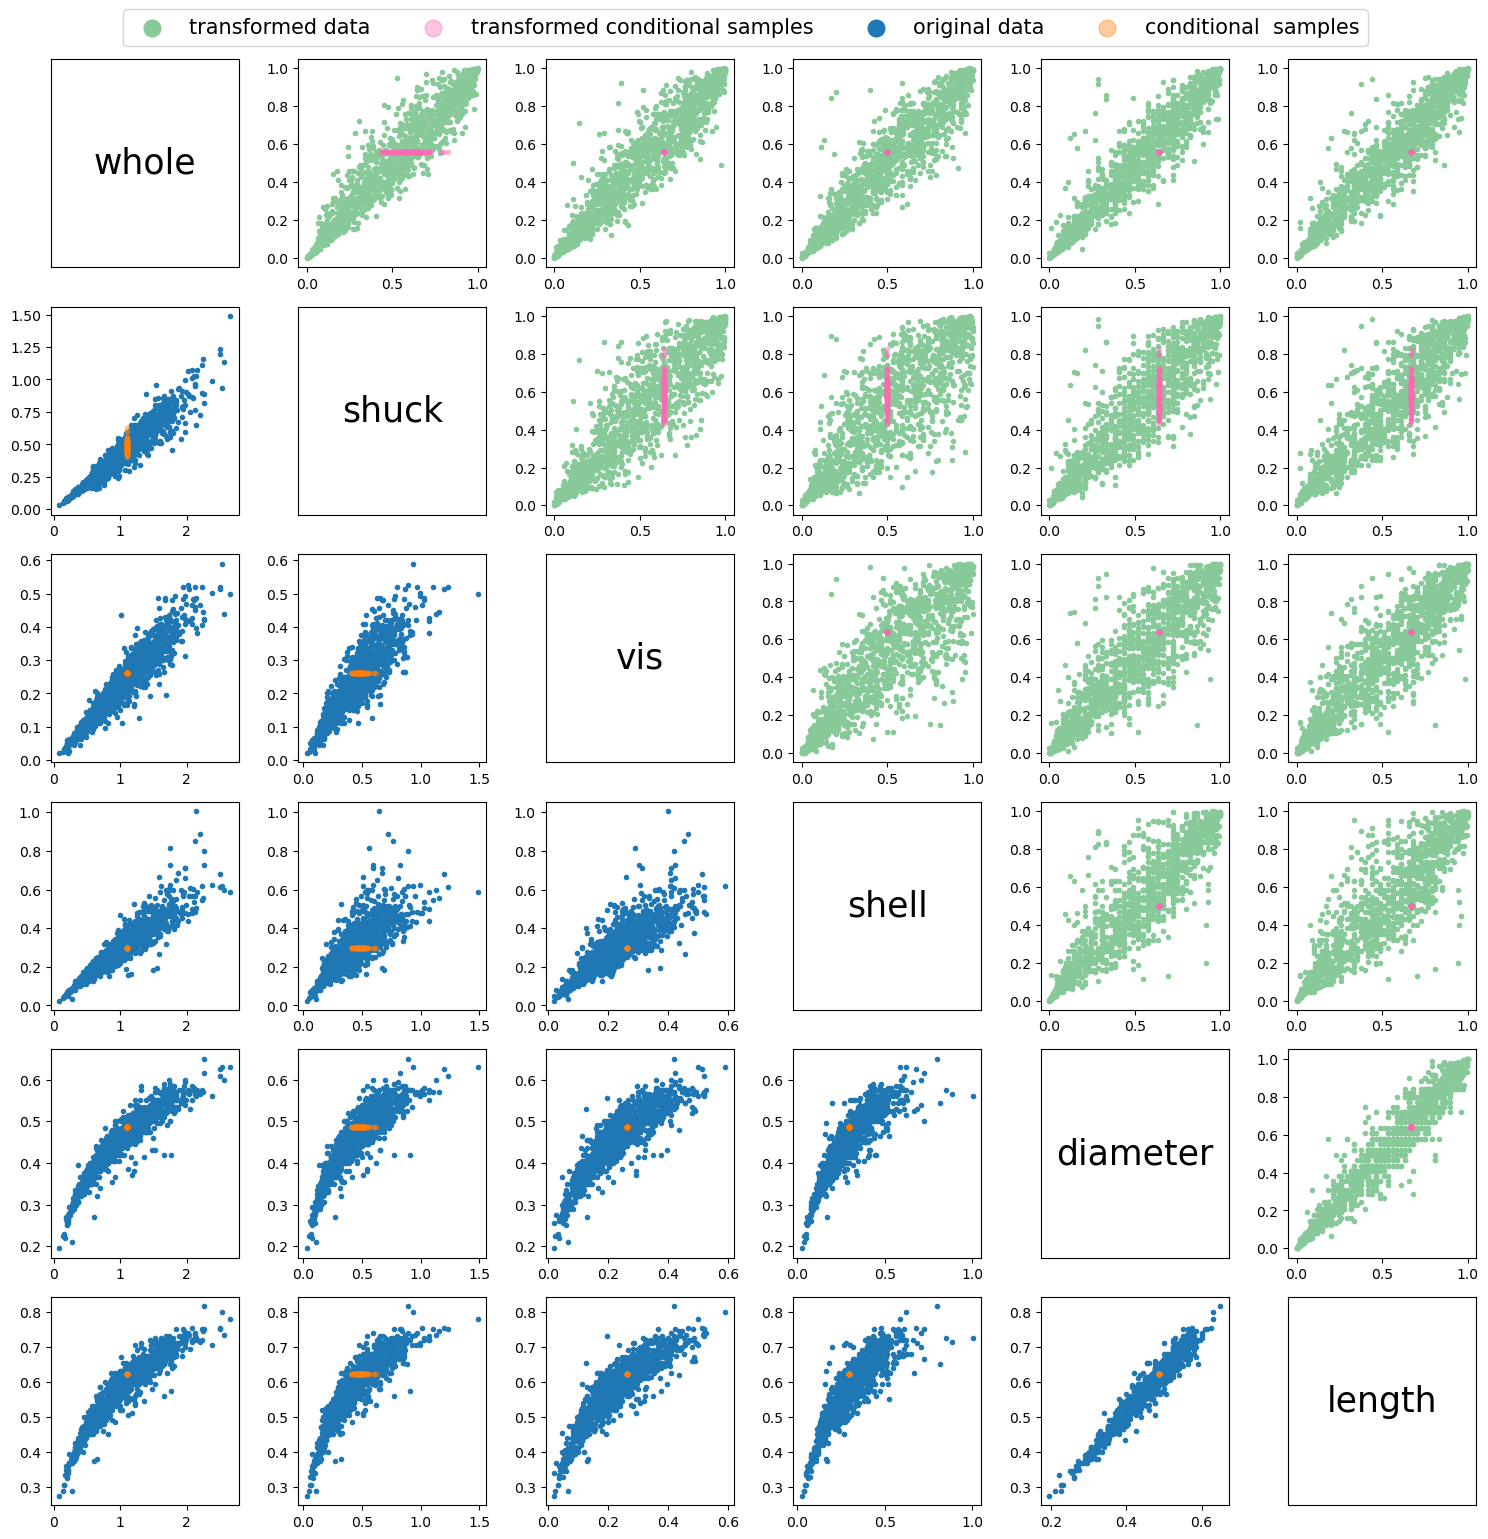

In [12]:
fig, axs = plt.subplots(6, 6, figsize=(15, 15))
ii = 0
jj = 0
for i in range(6):
    for j in range(6):
        ax = axs[i, j]
        if i > j:  # Lower diagonal
            if ii == 0:
        
                ax.scatter(x[:,j], x[:,i], marker='.',label = "original data")
                ax.scatter(xci[:,j], xci[:,i], marker='.', alpha = 0.4, label = "conditional  samples")
                ii = 1
            else:
                ax.scatter(x[:,j], x[:,i], marker='.')
                ax.scatter(xci[:,j], xci[:,i], marker='.', alpha = 0.4)
        elif i < j:  # Upper diagonal
            if jj == 0:
                ax.scatter(u[:,j], u[:,i], marker='.', color = '#88c999',  label  ='transformed data')
                ax.scatter(uci[:,j], uci[:,i], marker='.', alpha = 0.4, color = 'hotpink', label  ='transformed conditional samples')
                jj = 1
            else:   
                ax.scatter(u[:,j], u[:,i], marker='.', color = '#88c999')
                ax.scatter(uci[:,j], uci[:,i], marker='.', alpha = 0.4, color = 'hotpink')
        else:  # Main diagonal
            ax.text(0.5, 0.5, df.columns[i], horizontalalignment='center', verticalalignment='center', fontsize=25, color='black')
            ax.set_xticks([])
            ax.set_yticks([])
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4,markerscale=4, fontsize=15)
plt.tight_layout()
plt.show()

### Fitting a Copula to a Desired Sampling Order

As seen in the previous section, we can draw conditional samples of the variables at the end of the sampling order $s$. However, suppose we want to draw conditional samples of variables $2$ and $5$. the fitted copula above does not include a sampling order in $S$ where $[2,5]$ are at the end of $s$. Therefore, the vine copula needs to be refit in a manner that such a sampling order does exist. To do so, the  Dißmann Algorithm (Dißmann et al. 2013) has been altered as follows in Algorithm 4.

***

**Algorithm 4** Algorithm for conditionalizing.

***

**Input:** $Y_{conditioned}$, $Y_{conditioning}$, and data $U = [\mathbf{u}_{1}, \ldots, \mathbf{u}_{d}]$, of length 𝑛
, i.e., $\mathbf{u}=[𝑢_{11},...,𝑢_{𝑛1}]$

**Output:** R-vine copula specification in the form of triangular matrices, $M$, $P$ and $C$.

1. Calculate the empirical Kendall’s tau $\hat{\tau}_{j,k}$ for all possible variable pairs $\{j, k\}$, $1 \leq j < k \leq d$.
2. select $l - 1$ pairs of  $\{j, k\}$ with the highest $\hat{\tau}_{j,k}$, where $j$ and $k$ are both in $Y_{conditioning}$, and $l = length(Y_{conditioning})$, add these pairs to $T_1$.
3. Set $Y^{2}_{conditioning} = Y_{conditioning}$ and $Y^{2}_{conditioned} = Y_{conditioned}$.
4. **While** $length(T_1)$ < $length(\mathbf{u})$ **do** {add edges untill maximum number of edges in tree is reached} : 
   1. select a pair $\{j, k\}$ with the highest $\hat{\tau}_{j,k}$ that is not in $T_1$, where $j$ or $k$ is in $Y^{2}_{conditioned}$ and $j$ or $k$ is in $Y^{2}_{conditioning}$
   2. **if** $j$ is in $Y^{2}_{conditioned}$ **then**:
      1. remove $j$ from $Y^{2}_{conditioned}$
      2. add $j$ to $Y^{2}_{conditioning}$
   3. **else**:
      1. remove $k$ from $Y^{2}_{conditioned}$
      2. add $k$ to $Y^{2}_{conditioning}$
   4. add selected pair $\{j, k\}$ to $T_1$
5. For each edge $\{j, k\}$ in $T_1$, select a copula and estimate the corresponding parameter(s). Then transform $C_{j|k}( \mathbf{u}_{j}|\mathbf{u}_{k})$ and $C_{k|j}( \mathbf{u}_{k}|\mathbf{u}_{j})$ using the fitted copula  ${C}_{jk}$.
6. **for** $i = 2, \ldots, d - 1$ **do** {Iteration over the trees}:
   1. Set $Y^{i}_{conditioning}$ to the edge(s) in  $T_{i-1}$ that include all, or most of the variables in $Y_{conditioning}$.
   2. Set $Y^{i}_{conditioned}$ to the edge in $T_{i-1}$ that are not in $Y^{i}_{conditioning}$.
   3. Calculate the empirical Kendall’s tau $\hat{\tau}_{j,k|D}$ for all conditional variable pairs $\{j, k|D\}$ that can be part of tree $T_i$, i.e., two nodes that share a node in $T_{i-1}$.
   4. **if** $length(Y^{i}_{conditioning}) > 1$ **then**:
      1. select $l - 1$ pairs of $\{j, k|D\}$ with the highest $\hat{\tau}_{j,k|D}$, where both edges in the pair are in  $Y^{i}_{conditioning}$, and $l = length(Y^{i}_{conditioning})$, and add these pairs to $T_i$
   5. **While** $length(T_i)$ < $(length(\mathbf{u}) - i)$ **do** {add edges untill maximum number of edges in tree is reached}:
   
      1. select a pair $\{j, k|D\}$ with the highest $\hat{\tau}_{j,k}$ that is not in $T_i$, where one egde is in $Y^{i}_{conditioned}$ and the other is in $Y^{i}_{conditioning}$
      2. remove the edge that was in  $Y^{i}_{conditioned}$  from  $Y^{i}_{conditioned}$  and add this edge to $Y^{i}_{conditioning}$
      3. add selected pair $\{j, k|D\}$ to $T_i$  
   6. For each edge $\{j, k|D\}$ in $T_i$, select a conditional copula and estimate the corresponding parameter(s). Then transform
   $C_{j|k \cup D}(\mathbf{u}_{j}|\mathbf{u}_{k}, \mathbf{u}_{D})$ and  $C_{k|j \cup D}(\mathbf{u}_{k}|\mathbf{u}_{j}, \mathbf{u}_{D})$, using the fitted copula $C_{j,k|D}$.
8. **end for**

***

If $[2,5]$ need to be at the end of the sampling order $Y_{conditioned} = [2,5]$, and $Y_{conditioning}$ will consist of the remaining variables $[0,1,3,4]$. In Algorithm 4, the edges in $T_1$ that consist of nodes in $Y_{conditioning}$ are prioritized first, before adding edges that include nodes in $Y_{conditioned}$. 

the `conditionalvine` function can be used to fit a copula based on specific conditioning or conditionalized variables as follows. 

** Tree:  1
1,0  --->  Gumbel180 : parameters =  5.646871761976745
2,4  --->  Gumbel180 : parameters =  3.5974443116927945
3,0  --->  Gumbel180 : parameters =  4.891363224790164
0,4  --->  Gumbel180 : parameters =  5.28199025904998
4,5  --->  Gumbel180 : parameters =  6.401980791083808
** Tree:  2
1,3|0  --->  Student : parameters =  [-0.6498728754754225, 5.696870994081602]
2,0|4  --->  Joe180 : parameters =  1.0297355140045577
3,4|0  --->  Student : parameters =  [0.652445142963417, 7.791670144068236]
0,5|4  --->  Student : parameters =  [0.241231847781281, 17.26191304372896]
** Tree:  3
1,4|3,0  --->  Student : parameters =  [0.16626803574973129, 6.185482502632291]
2,5|0,4  --->  Joe180 : parameters =  1.013566343612041
3,5|4,0  --->  Gumbel90 : parameters =  1.1521026461023178
** Tree:  4
1,5|4,3,0  --->  Frank : parameters =  -0.5896648788321173
2,3|5,0,4  --->  Gaussian : parameters =  0.011737040396520761
** Tree:  5
1,2|5,4,3,0  --->  Frank : parameters =  1.4774167293421918


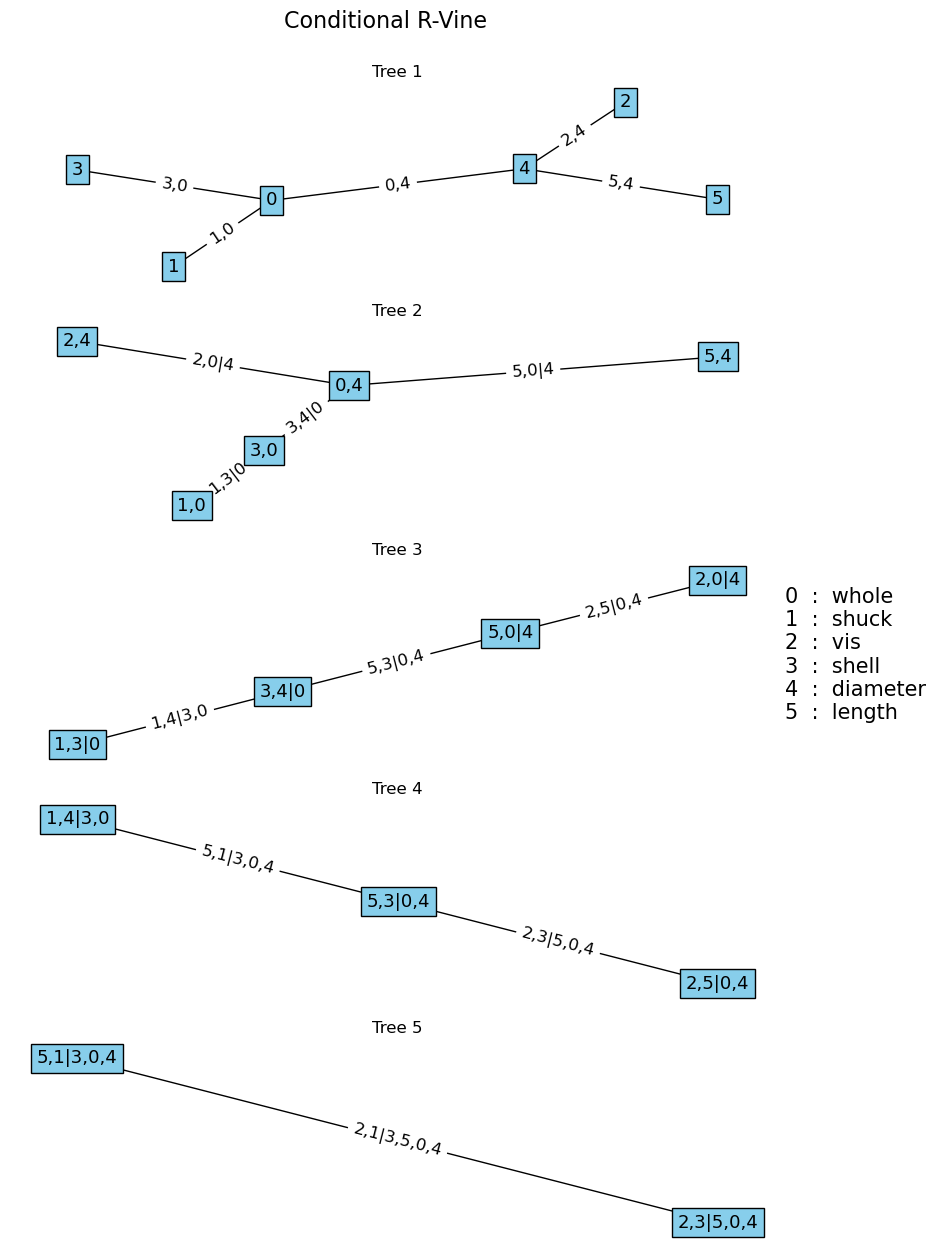

In [13]:
#fit copula based on a variable of interest
vint = [2,5] #variable of interest
Mc, Pc, Cc = conditionalvine(u, vint, cops,vine = 'R', condition = 1)
plotvine(Mc,variables = list(df.columns[:-1]), plottitle = 'Conditional R-Vine') #plot structure

Algorithm 4 can, like Algorithm 1, be adjusted to fit a D- or C-vine by setting the _vine_ argument to 'D' or 'C'. The _condition_ can be set to $2$  _vint_ is $Y_{conditioning}$ instead of $Y_{conditioned}$.

Using the `vincopconditionalsample` function, conditional samples can be generated based on the fitted copula above, $M_c$. The samples can be conditionalized on any initial segment of the sampling order. To showcase this in the following example we will only sample according to the first variable in the sampling order. In $M_c$ this is variable $4$, _diameter_.

In [14]:
Uc = np.array([0.9]) # ordered according to sampling order
n = 150
uci = vincopconditionalsample(Mc, Pc,Cc, n, Uc)
xci = uci.copy()
for i in range(len(df.columns[:-1])):
    namedist =  'dist'+ str(i)
    xci[:,i] = locals()[namedist][0].ppf(uci[:,i] , *locals()[namedist][1])
    

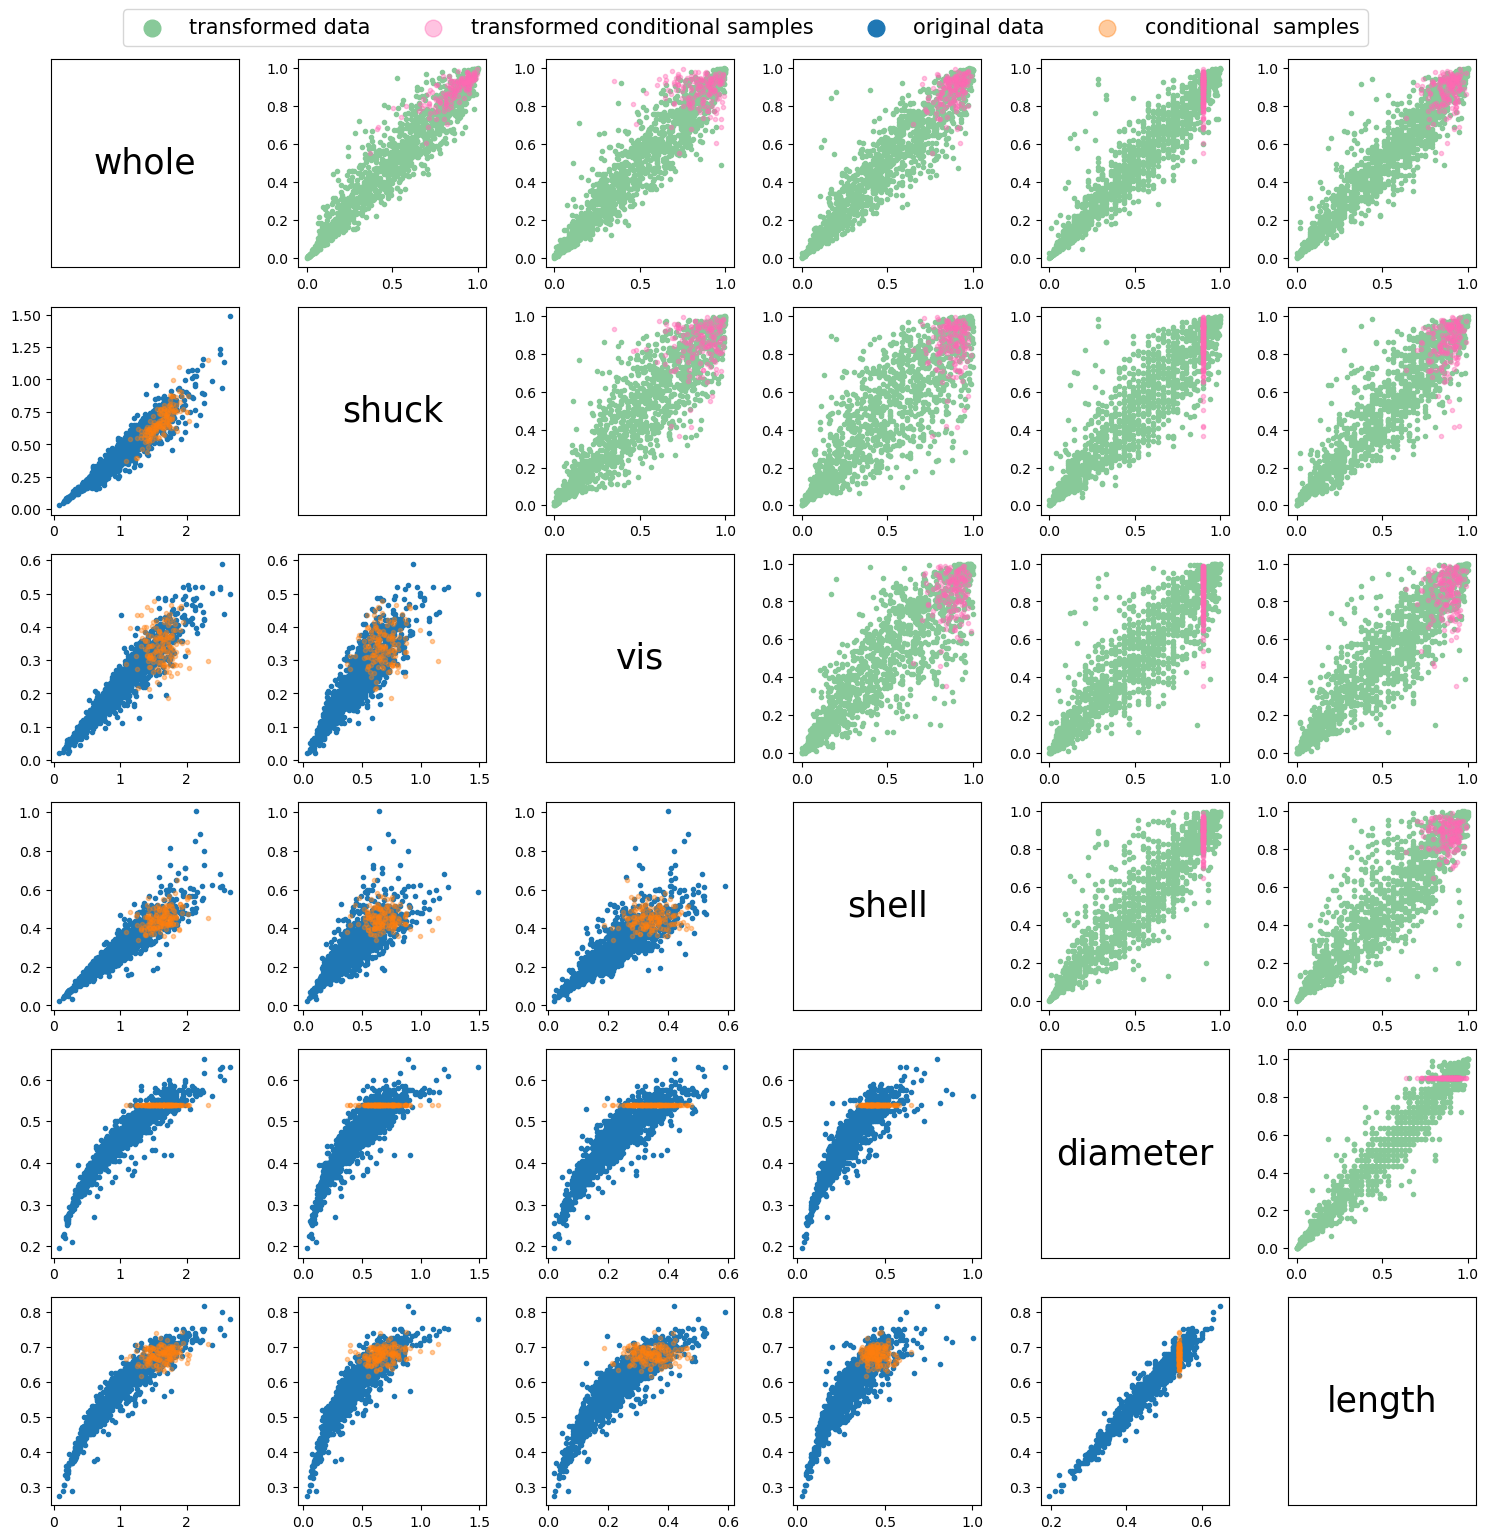

In [15]:
fig, axs = plt.subplots(6, 6, figsize=(15, 15))
ii = 0
jj = 0
for i in range(6):
    for j in range(6):
        ax = axs[i, j]
        if i > j:  # Lower diagonal
            if ii == 0:
        
                ax.scatter(x[:,j], x[:,i], marker='.',label = "original data")
                ax.scatter(xci[:,j], xci[:,i], marker='.', alpha = 0.4, label = "conditional  samples")
                ii = 1
            else:
                ax.scatter(x[:,j], x[:,i], marker='.')
                ax.scatter(xci[:,j], xci[:,i], marker='.', alpha = 0.4)
        elif i < j:  # Upper diagonal
            if jj == 0:
                ax.scatter(u[:,j], u[:,i], marker='.', color = '#88c999',  label  ='transformed data')
                ax.scatter(uci[:,j], uci[:,i], marker='.', alpha = 0.4, color = 'hotpink', label  ='transformed conditional samples')
                jj = 1
            else:   
                ax.scatter(u[:,j], u[:,i], marker='.', color = '#88c999')
                ax.scatter(uci[:,j], uci[:,i], marker='.', alpha = 0.4, color = 'hotpink')
        else:  # Main diagonal
            ax.text(0.5, 0.5, df.columns[i], horizontalalignment='center', verticalalignment='center', fontsize=25, color='black')
            ax.set_xticks([])
            ax.set_yticks([])
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.03), ncol=4,markerscale=4, fontsize=15)
plt.tight_layout()
plt.show()

## References 

Aas, K., Czado, C., Frigessi, A., & Bakken, H. (2009). Pair-copula constructions of multiple dependence. Insurance: Mathematics and Economics, 44(2), 182–198. https://doi.org/10.1016/j.insmatheco.2007.02.001

Cooke, R. M., Kurowicka, D., & Wilson, K. (2015). Sampling, conditionalizing, counting, merging, searching regular vines. Journal of Multivariate Analysis, 138, 4–18. https://doi.org/10.1016/j.jmva.2015.02.001

Czado, C., & Nagler, T. (2021). Vine Copula Based Modeling. Annual Review of Statistics and Its Application, 9, 453–477. https://doi.org/10.1146/annurev-statistics-040220-101153

Dißmann, J., Brechmann, E. C., Czado, C., & Kurowicka, D. (2013). Selecting and estimating regular vine copulae and application to financial returns. Computational Statistics and Data Analysis, 59(1), 52–69. https://doi.org/10.1016/j.csda.2012.08.010

Morales Napoles, O. (2011). Counting Vines. In D. Kurowicka & H. Joe (Eds.), Dependence Modeling. Vine Copula Handbook (pp. 189–218).


